# Autoregressive Model Testing (SARIMA & SARIMAX)

In [200]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [177]:
# Load data
df = pd.read_excel('data/Expo Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Data Preparation

In [212]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']
vol_macro_list = ['vol_LFPR', 'vol_CPI', 'vol_r', 'vol_M1', 'vol_GDP', 'vol_IM', 'vol_EX', 'vol_CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
train_end = '2024-01-01'
train_start = '2018-09-01'

In [191]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 2, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0, 
                     'Bitcoin_lag': 1, 'Tether_lag': 3, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                     'Cardano_lag': 2, 'USD Coin_lag': 0}
ar_orders['CPI'] = {'p': 2, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                    'Bitcoin_lag': 3, 'Tether_lag': 5, 'Litecoin_lag': 4, 'XRP_lag': 5, 'Ethereum_lag': 0, 'Dogecoin_lag': 6, 
                    'Cardano_lag': 2, 'USD Coin_lag': 2,}
ar_orders['r'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 0, 
                  'Bitcoin_lag': 6, 'Tether_lag': 5, 'Litecoin_lag': 5, 'XRP_lag': 3, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                  'Cardano_lag': 2, 'USD Coin_lag': 2}
ar_orders['M1'] = {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 0, 'Q': 1, 
                   'Bitcoin_lag': 1, 'Tether_lag': 2, 'Litecoin_lag': 2, 'XRP_lag': 5, 'Ethereum_lag': 2, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 0}
ar_orders['GDP'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                            'Bitcoin_lag': 0, 'Tether_lag': 2, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 4, 'Dogecoin_lag': 1, 
                            'Cardano_lag': 0, 'USD Coin_lag': 2}
ar_orders['IM'] = {'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 2, 'XRP_lag': 3, 'Ethereum_lag': 3, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 3, 'USD Coin_lag': 1}
ar_orders['EX'] = {'p': 1, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 4, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 6}
ar_orders['CC'] = {'p': 2, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 
                   'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 4, 'Ethereum_lag': 0, 'Dogecoin_lag': 3, 
                   'Cardano_lag': 0, 'USD Coin_lag': 4}
# ar_orders['PC1_macro'] = {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
#                           'Bitcoin_lag': 2, 'Tether_lag': 0, 'Litecoin_lag': 2, 'XRP_lag': 4, 'Ethereum_lag': 1, 'Dogecoin_lag': 4, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 4, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1, 'VIX_lag': 0}
# ar_orders['PC2_macro'] = {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 
#                           'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
#                           'Cardano_lag': 1, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0, 'VIX_lag': 0}

# ar_orders['CC 
# 
#  % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0}
# ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0}
# ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0}
# ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
# ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [180]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")

In [181]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=30, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [193]:
# variable = 'CC'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

## SARIMA(X) Model

In [171]:
from itertools import product
P = Q = range(0, 3)
D = [0, 1]
s = 12  # for monthly data

# All combinations of parameters

seasonal_combinations = list(product(P, D, Q))

In [173]:
def find_best_seasonal_order(y, macro, ar_orders, exog=None, seasonal_period=12, verbose=False):
    best_aic = np.inf
    best_model = None
    best_seasonal_order = None

    # Fixed p, d, q
    order = (
        ar_orders[macro]['p'],
        ar_orders[macro]['d'],
        ar_orders[macro]['q']
    )

    for P, D, Q in seasonal_combinations:
        seasonal_order = (P, D, Q, seasonal_period)

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(
                    y,
                    exog=exog,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_model = results
                    best_seasonal_order = seasonal_order

                if verbose:
                    print(f"Tried SARIMA{order}x{seasonal_order} AIC={results.aic:.2f}")

        except Exception as e:
            if verbose:
                print(f"Failed SARIMA{order}x{seasonal_order}: {e}")
            continue

    return order, best_seasonal_order, best_model

In [174]:
macro = "LFPR"
y = df[macro].dropna()

order, best_seasonal_order, best_model = find_best_seasonal_order(y, macro, ar_orders, seasonal_period=12, verbose=True)

print("Fixed order:", order)
print("Best seasonal order:", best_seasonal_order)
print("Best AIC:", best_model.aic)

Tried SARIMA(2, 0, 0)x(0, 0, 0, 12) AIC=-666.41
Tried SARIMA(2, 0, 0)x(0, 0, 1, 12) AIC=-571.24
Tried SARIMA(2, 0, 0)x(0, 0, 2, 12) AIC=2537.70
Tried SARIMA(2, 0, 0)x(0, 1, 0, 12) AIC=-515.16
Tried SARIMA(2, 0, 0)x(0, 1, 1, 12) AIC=-462.11
Tried SARIMA(2, 0, 0)x(0, 1, 2, 12) AIC=2585.32
Tried SARIMA(2, 0, 0)x(1, 0, 0, 12) AIC=-563.35
Tried SARIMA(2, 0, 0)x(1, 0, 1, 12) AIC=-561.27
Tried SARIMA(2, 0, 0)x(1, 0, 2, 12) AIC=2690.79
Tried SARIMA(2, 0, 0)x(1, 1, 0, 12) AIC=-436.71
Tried SARIMA(2, 0, 0)x(1, 1, 1, 12) AIC=-451.58
Tried SARIMA(2, 0, 0)x(1, 1, 2, 12) AIC=-425.25
Tried SARIMA(2, 0, 0)x(2, 0, 0, 12) AIC=-459.80
Tried SARIMA(2, 0, 0)x(2, 0, 1, 12) AIC=-459.76
Tried SARIMA(2, 0, 0)x(2, 0, 2, 12) AIC=2696.45
Tried SARIMA(2, 0, 0)x(2, 1, 0, 12) AIC=-403.23
Tried SARIMA(2, 0, 0)x(2, 1, 1, 12) AIC=-419.64
Tried SARIMA(2, 0, 0)x(2, 1, 2, 12) AIC=-417.30
Fixed order: (2, 0, 0)
Best seasonal order: (0, 0, 0, 12)
Best AIC: -666.4136103194911


In [147]:
def check_model_assumptions_arx(y_train, X_train, model_residuals):
    # Add constant to X
    X_const = add_constant(X_train)
    
    # 1. Breusch–Pagan test for heteroskedasticity
    ols_model = OLS(y_train, X_const).fit()
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)

    # 3. Breusch–Godfrey test
    bg_stat, bg_pvalue, _, _ = acorr_breusch_godfrey(ols_model, nlags=1)

    # 4. Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)

    # 5. Anderson-Darling test
    ad_result = anderson(model_residuals)
    ad_stat = ad_result.statistic
    ad_crit = list(zip(ad_result.significance_level, ad_result.critical_values))

    # 6. Mean of residuals
    mean_resid = model_residuals.mean()

    return {
        "Breusch-Pagan p": bp_pvalue,
        "Breusch-Godfrey p": bg_pvalue,
        "Shapiro p": shapiro_p,
        "Anderson stat": ad_stat,
        "Anderson crit": ad_crit,
        "Mean resid": mean_resid,
    }

In [216]:
def run_model(df, macro, asset, plot=False):
    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})
    
    # Unpack ARIMA and seasonal orders
    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']

    # Extract asset-specific lag
    asset_lag_key = f"{asset}_lag"
    asset_lag = order_dict.get(asset_lag_key, 0)
    asset_lag = 0

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[train_start:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + asset ==== ###
    df_temp = df[[macro, asset]].dropna().copy()

    # Create lagged asset columns
    for lag in range(1, asset_lag + 1):
        df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)

    exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]
    df_temp = df_temp.dropna()

    exog = df_temp[exog_cols]
    target_arx = df_temp[macro]

    train_endog_arx = target_arx[train_start:train_end]
    train_exog = exog[train_start:train_end]
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(1, 1, 0, 12))
        arx_result = arx_model.fit(disp=False)

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}, asset: {asset}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align index for plotting
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar, label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with {asset})', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
        plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]
    plt.figure(figsize=(8, 4))
    sns.histplot(arx_result.resid, kde=True, bins=30, color='skyblue')
    plt.title("Residuals Histogram with KDE")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    assumptions = check_model_assumptions_arx(train_endog_arx, train_exog, arx_result.resid)
    residuals = arx_result.resid
    # Combine into a DataFrame
    resid_df = residuals.to_frame(name='Residual')
    resid_df.index.name = 'Month'  # Optional: label the index

    # Print the first few rows
    print(resid_df)
    return pd.DataFrame(metrics).set_index('Model'), assumptions


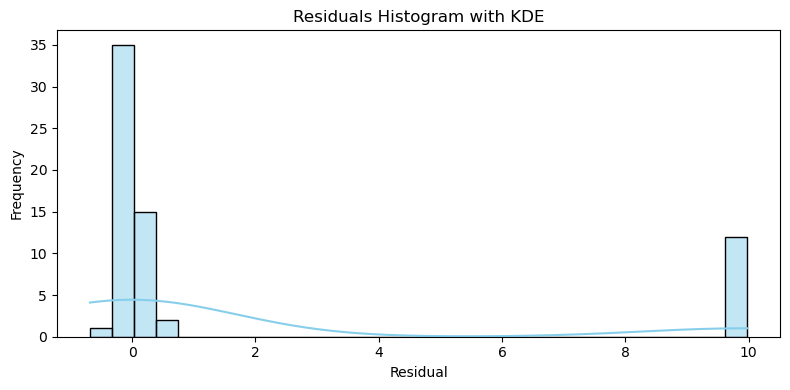

            Residual
Month               
2018-09-01  9.976565
2018-10-01  9.932361
2018-11-01  9.860431
2018-12-01  9.969820
2019-01-01  9.960911
2019-02-01  9.897662
2019-03-01  9.847907
2019-04-01  9.782122
2019-05-01  9.960387
2019-06-01  9.964830
2019-07-01  9.976726
2019-08-01  9.931044
2019-09-01 -0.034957
2019-10-01  0.013360
2019-11-01  0.050573
2019-12-01 -0.079074
2020-01-01 -0.049398
2020-02-01 -0.011276
2020-03-01 -0.218462
2020-04-01 -0.684940
2020-05-01  0.246788
2020-06-01  0.015780
2020-07-01 -0.060878
2020-08-01  0.089596
2020-09-01 -0.194149
2020-10-01  0.089417
2020-11-01 -0.119727
2020-12-01 -0.005173
2021-01-01 -0.074973
2021-02-01  0.039515
2021-03-01  0.175352
2021-04-01  0.417902
2021-05-01 -0.121364
2021-06-01  0.059095
2021-07-01 -0.004985
2021-08-01 -0.087829
2021-09-01  0.031763
2021-10-01 -0.033609
2021-11-01  0.077843
2021-12-01  0.032710
2022-01-01  0.113536
2022-02-01 -0.005633
2022-03-01  0.216153
2022-04-01  0.458092
2022-05-01 -0.157408
2022-06-01 -0

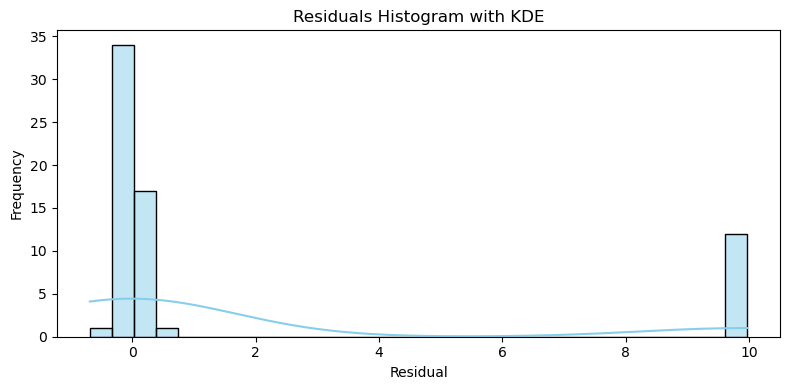

            Residual
Month               
2018-09-01  9.965844
2018-10-01  9.925197
2018-11-01  9.859779
2018-12-01  9.943991
2019-01-01  9.951092
2019-02-01  9.891044
2019-03-01  9.882303
2019-04-01  9.795176
2019-05-01  9.947879
2019-06-01  9.939412
2019-07-01  9.932272
2019-08-01  9.905170
2019-09-01 -0.054972
2019-10-01  0.001397
2019-11-01  0.002898
2019-12-01 -0.081273
2020-01-01 -0.076811
2020-02-01 -0.000924
2020-03-01 -0.261341
2020-04-01 -0.686332
2020-05-01  0.217395
2020-06-01  0.019381
2020-07-01 -0.066559
2020-08-01  0.090686
2020-09-01 -0.190965
2020-10-01  0.104793
2020-11-01 -0.128483
2020-12-01  0.028617
2021-01-01 -0.056747
2021-02-01  0.032382
2021-03-01  0.148864
2021-04-01  0.360306
2021-05-01 -0.113282
2021-06-01  0.093061
2021-07-01  0.024075
2021-08-01 -0.101800
2021-09-01  0.045506
2021-10-01 -0.024018
2021-11-01  0.070274
2021-12-01  0.057859
2022-01-01  0.102964
2022-02-01 -0.019514
2022-03-01  0.195930
2022-04-01  0.426520
2022-05-01 -0.163532
2022-06-01 -0

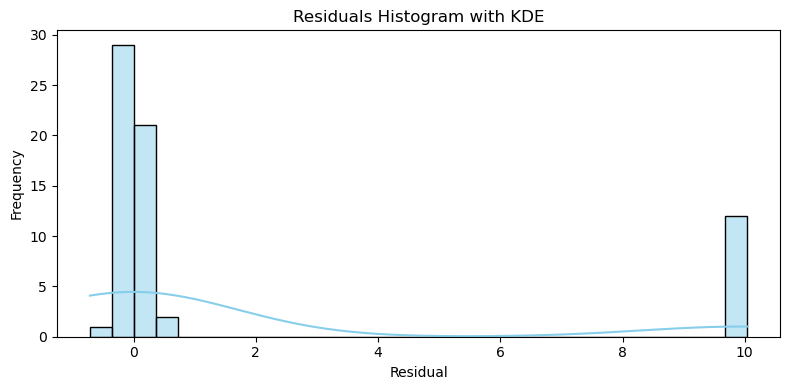

             Residual
Month                
2018-09-01  10.038771
2018-10-01  10.013126
2018-11-01   9.957544
2018-12-01   9.989348
2019-01-01   9.994071
2019-02-01   9.944697
2019-03-01   9.905861
2019-04-01   9.837116
2019-05-01   9.981366
2019-06-01   9.999849
2019-07-01   9.985039
2019-08-01   9.946374
2019-09-01  -0.064409
2019-10-01  -0.023591
2019-11-01  -0.028233
2019-12-01  -0.060364
2020-01-01  -0.053184
2020-02-01  -0.004007
2020-03-01  -0.218744
2020-04-01  -0.716751
2020-05-01   0.260831
2020-06-01   0.022851
2020-07-01  -0.022902
2020-08-01   0.115918
2020-09-01  -0.194984
2020-10-01   0.080316
2020-11-01  -0.149995
2020-12-01   0.032589
2021-01-01  -0.046533
2021-02-01   0.040363
2021-03-01   0.170023
2021-04-01   0.409413
2021-05-01  -0.079846
2021-06-01   0.046679
2021-07-01   0.030025
2021-08-01  -0.076352
2021-09-01   0.058411
2021-10-01  -0.029545
2021-11-01   0.086046
2021-12-01   0.022129
2022-01-01   0.094693
2022-02-01  -0.018080
2022-03-01   0.207604
2022-04-01

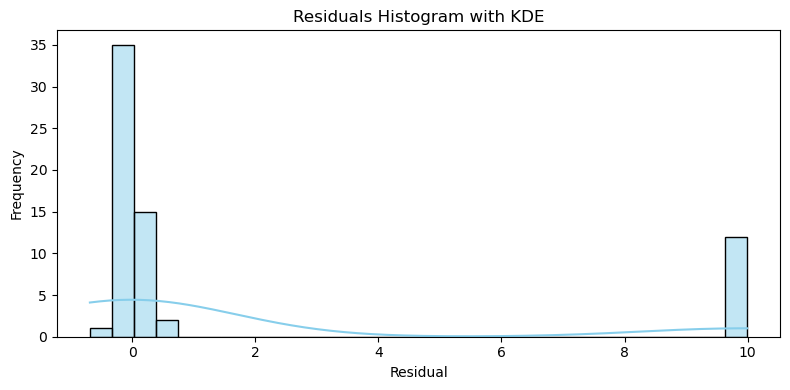

            Residual
Month               
2018-09-01  9.992926
2018-10-01  9.976950
2018-11-01  9.905156
2018-12-01  9.967729
2019-01-01  9.979844
2019-02-01  9.922374
2019-03-01  9.885906
2019-04-01  9.805643
2019-05-01  9.944598
2019-06-01  9.961697
2019-07-01  9.953317
2019-08-01  9.925248
2019-09-01 -0.056040
2019-10-01 -0.019931
2019-11-01 -0.011836
2019-12-01 -0.081375
2020-01-01 -0.079871
2020-02-01 -0.023908
2020-03-01 -0.234661
2020-04-01 -0.687784
2020-05-01  0.272602
2020-06-01  0.038804
2020-07-01 -0.025434
2020-08-01  0.096544
2020-09-01 -0.184063
2020-10-01  0.095317
2020-11-01 -0.143136
2020-12-01  0.003348
2021-01-01 -0.092588
2021-02-01  0.037981
2021-03-01  0.132379
2021-04-01  0.394217
2021-05-01 -0.125341
2021-06-01  0.064392
2021-07-01  0.011844
2021-08-01 -0.078177
2021-09-01  0.038285
2021-10-01 -0.035849
2021-11-01  0.081527
2021-12-01  0.036290
2022-01-01  0.100713
2022-02-01 -0.006568
2022-03-01  0.199821
2022-04-01  0.431512
2022-05-01 -0.170197
2022-06-01 -0

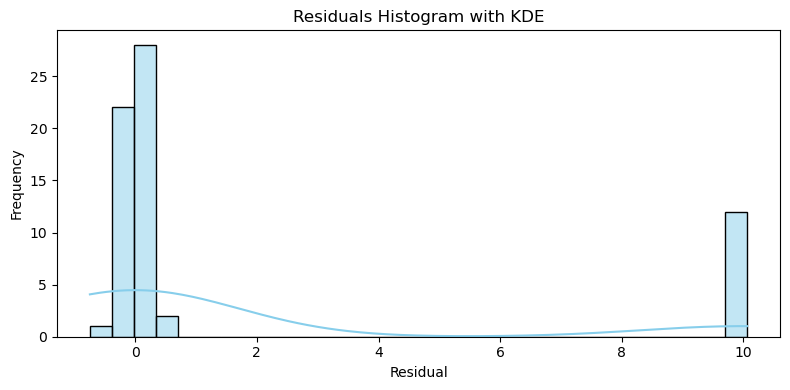

             Residual
Month                
2018-09-01  10.062274
2018-10-01  10.024251
2018-11-01   9.976404
2018-12-01  10.013169
2019-01-01  10.012511
2019-02-01   9.964026
2019-03-01   9.930791
2019-04-01   9.883329
2019-05-01  10.019999
2019-06-01  10.014019
2019-07-01  10.003628
2019-08-01   9.980871
2019-09-01  -0.058564
2019-10-01  -0.006894
2019-11-01  -0.020417
2019-12-01  -0.031041
2020-01-01  -0.046542
2020-02-01   0.060598
2020-03-01  -0.221676
2020-04-01  -0.746693
2020-05-01   0.221605
2020-06-01   0.001795
2020-07-01   0.008901
2020-08-01   0.143870
2020-09-01  -0.187286
2020-10-01   0.088097
2020-11-01  -0.147660
2020-12-01   0.002165
2021-01-01  -0.073689
2021-02-01   0.020684
2021-03-01   0.158959
2021-04-01   0.404355
2021-05-01  -0.081260
2021-06-01   0.056153
2021-07-01   0.018558
2021-08-01  -0.090684
2021-09-01   0.047684
2021-10-01  -0.042521
2021-11-01   0.091669
2021-12-01   0.016624
2022-01-01   0.115656
2022-02-01  -0.045741
2022-03-01   0.206057
2022-04-01

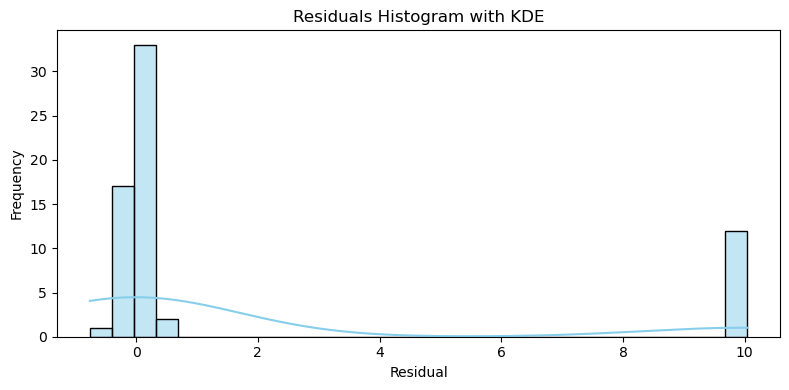

             Residual
Month                
2018-09-01  10.041153
2018-10-01  10.006446
2018-11-01   9.957225
2018-12-01  10.007090
2019-01-01  10.006320
2019-02-01   9.963673
2019-03-01   9.922601
2019-04-01   9.887776
2019-05-01   9.999063
2019-06-01  10.005766
2019-07-01   9.998957
2019-08-01   9.964466
2019-09-01  -0.047022
2019-10-01  -0.004425
2019-11-01  -0.016319
2019-12-01  -0.058798
2020-01-01  -0.052735
2020-02-01  -0.011044
2020-03-01  -0.226671
2020-04-01  -0.761530
2020-05-01   0.247360
2020-06-01   0.027860
2020-07-01   0.000017
2020-08-01   0.134166
2020-09-01  -0.188160
2020-10-01   0.103397
2020-11-01  -0.130844
2020-12-01   0.007545
2021-01-01  -0.072984
2021-02-01   0.018386
2021-03-01   0.155761
2021-04-01   0.378335
2021-05-01  -0.112671
2021-06-01   0.040451
2021-07-01  -0.004477
2021-08-01  -0.094327
2021-09-01   0.039853
2021-10-01  -0.047862
2021-11-01   0.070201
2021-12-01   0.023760
2022-01-01   0.108805
2022-02-01  -0.001096
2022-03-01   0.203342
2022-04-01

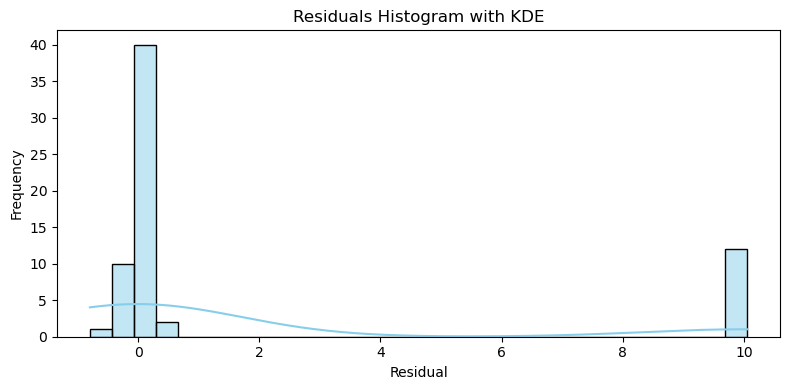

             Residual
Month                
2018-09-01  10.051880
2018-10-01  10.018487
2018-11-01   9.987237
2018-12-01  10.023835
2019-01-01  10.022808
2019-02-01   9.989137
2019-03-01   9.952926
2019-04-01   9.916918
2019-05-01  10.026004
2019-06-01  10.025466
2019-07-01  10.018432
2019-08-01   9.980558
2019-09-01  -0.035177
2019-10-01   0.000842
2019-11-01  -0.017468
2019-12-01  -0.042241
2020-01-01  -0.038501
2020-02-01  -0.016273
2020-03-01  -0.233244
2020-04-01  -0.796039
2020-05-01   0.235367
2020-06-01  -0.009111
2020-07-01   0.001702
2020-08-01   0.128573
2020-09-01  -0.183030
2020-10-01   0.098294
2020-11-01  -0.131474
2020-12-01  -0.005324
2021-01-01  -0.084941
2021-02-01  -0.006199
2021-03-01   0.120042
2021-04-01   0.363030
2021-05-01  -0.119739
2021-06-01   0.025516
2021-07-01  -0.017019
2021-08-01  -0.089758
2021-09-01   0.016700
2021-10-01  -0.048434
2021-11-01   0.061837
2021-12-01   0.019244
2022-01-01   0.090980
2022-02-01  -0.004273
2022-03-01   0.208311
2022-04-01

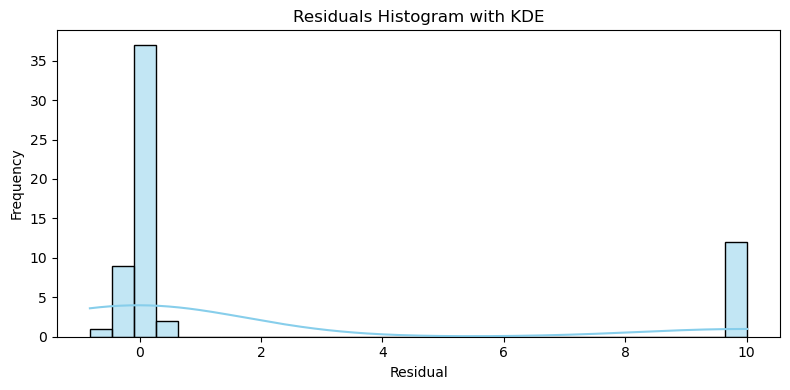

             Residual
Month                
2019-01-01  10.001904
2019-02-01   9.982782
2019-03-01   9.930607
2019-04-01   9.890384
2019-05-01  10.007225
2019-06-01   9.994166
2019-07-01   9.997133
2019-08-01   9.954994
2019-09-01   9.984659
2019-10-01   9.969726
2019-11-01   9.927329
2019-12-01   9.927963
2020-01-01  -0.074691
2020-02-01  -0.049643
2020-03-01  -0.259587
2020-04-01  -0.817768
2020-05-01   0.206385
2020-06-01  -0.032786
2020-07-01  -0.041536
2020-08-01   0.096420
2020-09-01  -0.199399
2020-10-01   0.084865
2020-11-01  -0.123271
2020-12-01   0.012173
2021-01-01  -0.105674
2021-02-01  -0.027230
2021-03-01   0.082140
2021-04-01   0.292866
2021-05-01  -0.149896
2021-06-01  -0.003294
2021-07-01  -0.057614
2021-08-01  -0.115848
2021-09-01  -0.017658
2021-10-01  -0.063241
2021-11-01   0.047026
2021-12-01   0.009413
2022-01-01   0.080233
2022-02-01  -0.021690
2022-03-01   0.189682
2022-04-01   0.511528
2022-05-01  -0.180722
2022-06-01  -0.073309
2022-07-01  -0.083452
2022-08-01

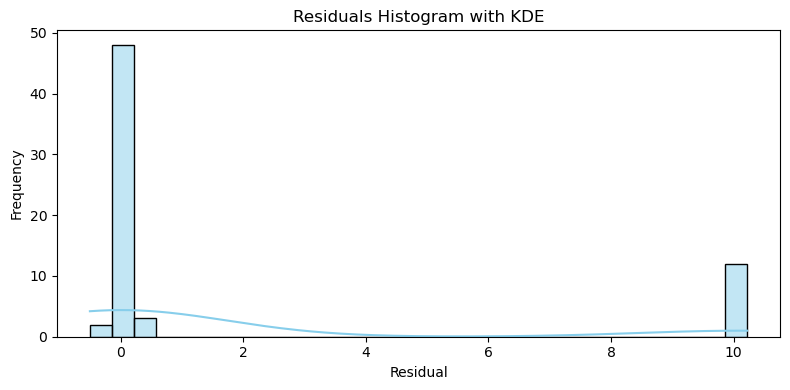

             Residual
Month                
2018-09-01  10.167813
2018-10-01  10.125301
2018-11-01  10.155141
2018-12-01  10.168723
2019-01-01  10.222376
2019-02-01  10.121088
2019-03-01  10.071582
2019-04-01  10.027356
2019-05-01  10.132609
2019-06-01  10.173400
2019-07-01  10.146815
2019-08-01  10.117799
2019-09-01   0.007444
2019-10-01   0.028946
2019-11-01  -0.061549
2019-12-01  -0.062085
2020-01-01  -0.121504
2020-02-01   0.020016
2020-03-01  -0.055703
2020-04-01  -0.507056
2020-05-01   0.459752
2020-06-01   0.140370
2020-07-01   0.104595
2020-08-01   0.176664
2020-09-01  -0.091752
2020-10-01   0.197093
2020-11-01   0.024734
2020-12-01   0.028845
2021-01-01  -0.042609
2021-02-01   0.124678
2021-03-01   0.152225
2021-04-01   0.312072
2021-05-01  -0.133713
2021-06-01  -0.029737
2021-07-01  -0.025017
2021-08-01  -0.083341
2021-09-01  -0.018598
2021-10-01  -0.005724
2021-11-01   0.020113
2021-12-01   0.121966
2022-01-01   0.076928
2022-02-01   0.020914
2022-03-01   0.167449
2022-04-01

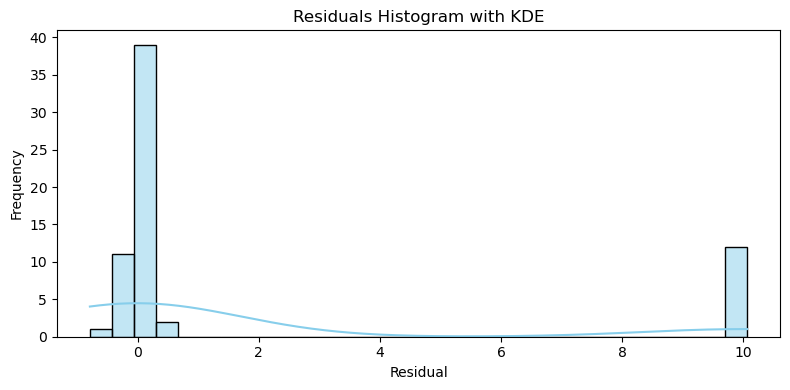

             Residual
Month                
2018-09-01  10.064543
2018-10-01  10.024627
2018-11-01   9.989444
2018-12-01  10.023270
2019-01-01  10.026588
2019-02-01   9.990493
2019-03-01   9.951788
2019-04-01   9.917209
2019-05-01  10.022100
2019-06-01  10.022495
2019-07-01  10.025492
2019-08-01   9.982507
2019-09-01  -0.043528
2019-10-01   0.001929
2019-11-01  -0.011761
2019-12-01  -0.035325
2020-01-01  -0.038228
2020-02-01  -0.017383
2020-03-01  -0.229045
2020-04-01  -0.789238
2020-05-01   0.258510
2020-06-01   0.008920
2020-07-01   0.010547
2020-08-01   0.141751
2020-09-01  -0.177691
2020-10-01   0.102971
2020-11-01  -0.122114
2020-12-01   0.004823
2021-01-01  -0.075973
2021-02-01  -0.001309
2021-03-01   0.129609
2021-04-01   0.362782
2021-05-01  -0.111355
2021-06-01   0.031753
2021-07-01  -0.010540
2021-08-01  -0.079444
2021-09-01   0.021780
2021-10-01  -0.043181
2021-11-01   0.061440
2021-12-01   0.020745
2022-01-01   0.093811
2022-02-01   0.000049
2022-03-01   0.207981
2022-04-01

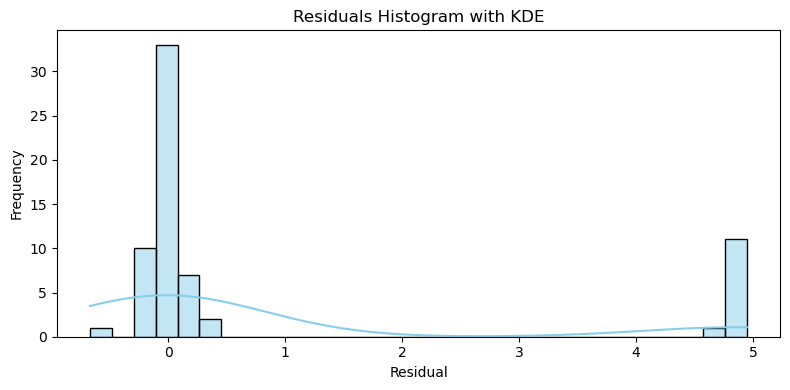

            Residual
Month               
2018-09-01  4.933982
2018-10-01  4.889717
2018-11-01  4.913262
2018-12-01  4.948115
2019-01-01  4.887942
2019-02-01  4.823743
2019-03-01  4.770435
2019-04-01  4.738168
2019-05-01  4.885425
2019-06-01  4.908203
2019-07-01  4.890735
2019-08-01  4.874478
2019-09-01 -0.032800
2019-10-01 -0.008517
2019-11-01 -0.044645
2019-12-01 -0.068389
2020-01-01 -0.076835
2020-02-01 -0.009202
2020-03-01 -0.140569
2020-04-01 -0.668349
2020-05-01  0.160680
2020-06-01 -0.033098
2020-07-01  0.027089
2020-08-01  0.088213
2020-09-01 -0.188497
2020-10-01  0.089844
2020-11-01 -0.145398
2020-12-01 -0.037550
2021-01-01 -0.116458
2021-02-01 -0.049118
2021-03-01  0.073933
2021-04-01  0.325989
2021-05-01 -0.142116
2021-06-01 -0.079017
2021-07-01 -0.091531
2021-08-01 -0.134728
2021-09-01 -0.010426
2021-10-01 -0.133978
2021-11-01 -0.009454
2021-12-01 -0.038189
2022-01-01  0.035887
2022-02-01 -0.061772
2022-03-01  0.042341
2022-04-01  0.400907
2022-05-01 -0.180650
2022-06-01 -0

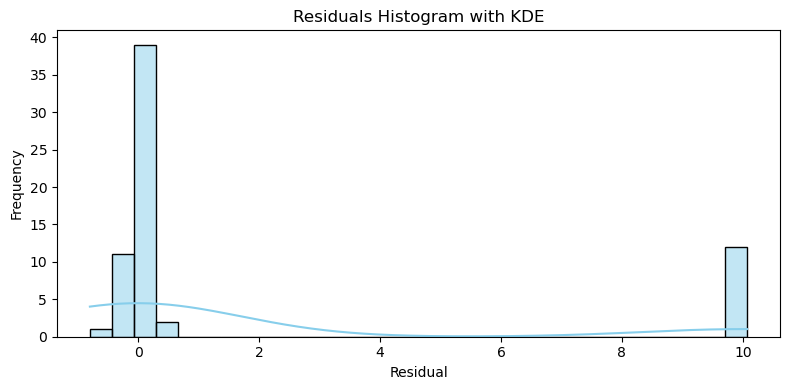

             Residual
Month                
2018-09-01  10.071025
2018-10-01  10.033177
2018-11-01   9.997293
2018-12-01  10.033792
2019-01-01  10.033560
2019-02-01   9.997322
2019-03-01   9.960871
2019-04-01   9.924464
2019-05-01  10.034130
2019-06-01  10.034021
2019-07-01  10.033885
2019-08-01   9.997933
2019-09-01  -0.036898
2019-10-01   0.001940
2019-11-01  -0.008485
2019-12-01  -0.036198
2020-01-01  -0.035221
2020-02-01  -0.008381
2020-03-01  -0.221749
2020-04-01  -0.798233
2020-05-01   0.199706
2020-06-01   0.016314
2020-07-01   0.020712
2020-08-01   0.128853
2020-09-01  -0.177628
2020-10-01   0.091398
2020-11-01  -0.119863
2020-12-01  -0.002906
2021-01-01  -0.079554
2021-02-01  -0.003922
2021-03-01   0.131309
2021-04-01   0.378850
2021-05-01  -0.088038
2021-06-01   0.021066
2021-07-01  -0.015795
2021-08-01  -0.082205
2021-09-01   0.018173
2021-10-01  -0.041453
2021-11-01   0.066070
2021-12-01   0.029329
2022-01-01   0.101907
2022-02-01   0.007120
2022-03-01   0.129099
2022-04-01

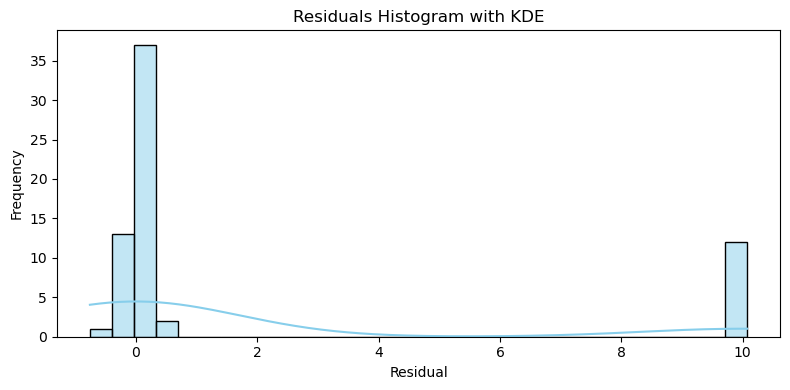

             Residual
Month                
2018-09-01  10.072398
2018-10-01  10.035262
2018-11-01   9.998629
2018-12-01  10.035107
2019-01-01  10.035262
2019-02-01   9.998590
2019-03-01   9.962136
2019-04-01   9.925635
2019-05-01  10.035376
2019-06-01  10.035191
2019-07-01  10.035148
2019-08-01   9.998607
2019-09-01  -0.037327
2019-10-01   0.006584
2019-11-01  -0.007942
2019-12-01  -0.036686
2020-01-01  -0.028554
2020-02-01   0.000350
2020-03-01  -0.223032
2020-04-01  -0.759223
2020-05-01   0.047438
2020-06-01   0.081596
2020-07-01  -0.101690
2020-08-01   0.126667
2020-09-01  -0.184365
2020-10-01   0.122561
2020-11-01  -0.126739
2020-12-01   0.013303
2021-01-01  -0.068299
2021-02-01   0.008359
2021-03-01   0.163734
2021-04-01   0.453078
2021-05-01  -0.067986
2021-06-01  -0.005398
2021-07-01   0.042637
2021-08-01  -0.099832
2021-09-01   0.053254
2021-10-01  -0.058138
2021-11-01   0.087354
2021-12-01   0.013880
2022-01-01   0.099367
2022-02-01  -0.012347
2022-03-01   0.171462
2022-04-01

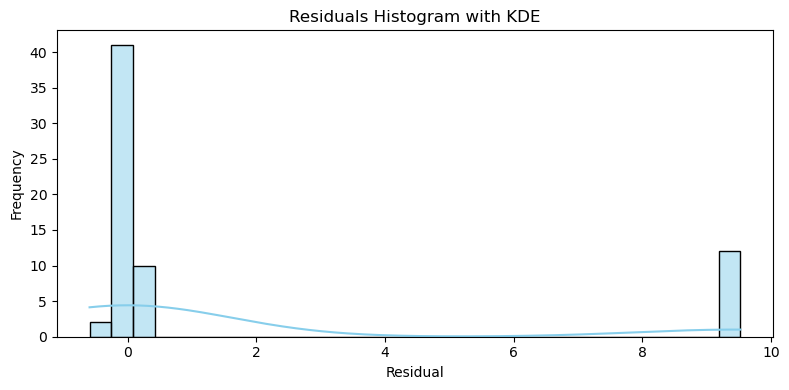

            Residual
Month               
2018-09-01  9.525822
2018-10-01  9.481520
2018-11-01  9.451986
2018-12-01  9.488660
2019-01-01  9.503933
2019-02-01  9.451986
2019-03-01  9.415561
2019-04-01  9.365752
2019-05-01  9.488719
2019-06-01  9.488660
2019-07-01  9.507197
2019-08-01  9.451986
2019-09-01 -0.037278
2019-10-01  0.033290
2019-11-01 -0.011606
2019-12-01 -0.026054
2020-01-01 -0.004559
2020-02-01 -0.011539
2020-03-01 -0.215566
2020-04-01 -0.593978
2020-05-01  0.160781
2020-06-01  0.047299
2020-07-01 -0.278697
2020-08-01  0.137565
2020-09-01 -0.238375
2020-10-01 -0.027603
2020-11-01 -0.129647
2020-12-01 -0.037284
2021-01-01 -0.177935
2021-02-01 -0.008702
2021-03-01  0.097846
2021-04-01  0.256913
2021-05-01 -0.068038
2021-06-01  0.002940
2021-07-01  0.019749
2021-08-01 -0.087229
2021-09-01  0.031583
2021-10-01 -0.114102
2021-11-01  0.066339
2021-12-01  0.007617
2022-01-01  0.009737
2022-02-01  0.011824
2022-03-01  0.187040
2022-04-01  0.366159
2022-05-01 -0.079387
2022-06-01 -0

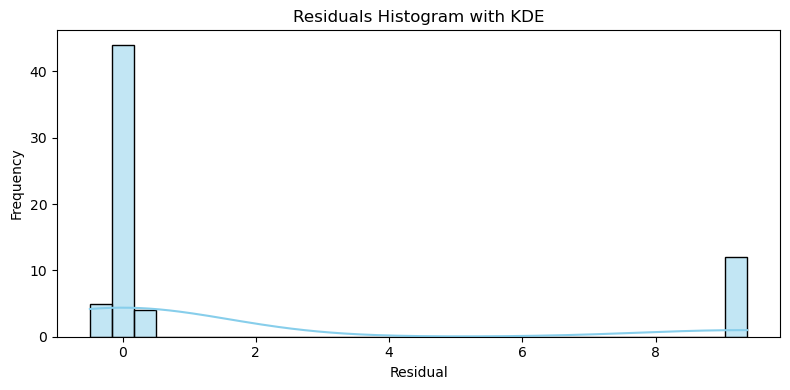

            Residual
Month               
2018-09-01  9.374910
2018-10-01  9.336591
2018-11-01  9.301074
2018-12-01  9.337748
2019-01-01  9.335893
2019-02-01  9.301074
2019-03-01  9.264649
2019-04-01  9.223663
2019-05-01  9.337806
2019-06-01  9.337748
2019-07-01  9.347129
2019-08-01  9.301074
2019-09-01 -0.037278
2019-10-01 -0.001802
2019-11-01 -0.011828
2019-12-01 -0.037407
2020-01-01  0.038335
2020-02-01 -0.012295
2020-03-01 -0.202039
2020-04-01 -0.492866
2020-05-01  0.171629
2020-06-01  0.070253
2020-07-01 -0.281713
2020-08-01  0.151996
2020-09-01 -0.233685
2020-10-01 -0.043858
2020-11-01 -0.129296
2020-12-01 -0.043711
2021-01-01 -0.191087
2021-02-01 -0.005755
2021-03-01  0.082920
2021-04-01  0.168466
2021-05-01 -0.064066
2021-06-01 -0.010554
2021-07-01  0.019830
2021-08-01 -0.081292
2021-09-01  0.024255
2021-10-01 -0.131837
2021-11-01  0.062812
2021-12-01  0.000226
2022-01-01  0.026513
2022-02-01  0.011813
2022-03-01  0.206935
2022-04-01  0.243422
2022-05-01 -0.093870
2022-06-01 -0

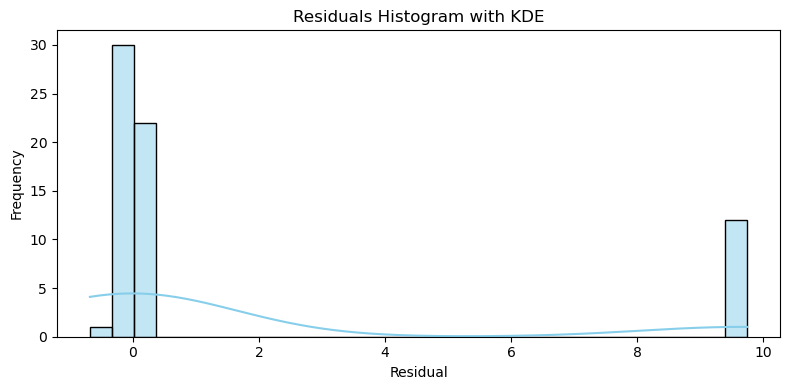

            Residual
Month               
2018-09-01  9.695072
2018-10-01  9.703426
2018-11-01  9.663742
2018-12-01  9.685086
2019-01-01  9.744469
2019-02-01  9.631585
2019-03-01  9.577325
2019-04-01  9.591714
2019-05-01  9.668065
2019-06-01  9.705673
2019-07-01  9.689986
2019-08-01  9.717882
2019-09-01 -0.034949
2019-10-01 -0.029703
2019-11-01 -0.021118
2019-12-01 -0.053249
2020-01-01 -0.091758
2020-02-01  0.015244
2020-03-01 -0.103046
2020-04-01 -0.682423
2020-05-01  0.295547
2020-06-01  0.053032
2020-07-01  0.036473
2020-08-01  0.009377
2020-09-01 -0.212455
2020-10-01  0.076991
2020-11-01 -0.060014
2020-12-01 -0.044785
2021-01-01 -0.077599
2021-02-01  0.040146
2021-03-01  0.040456
2021-04-01  0.306459
2021-05-01 -0.072815
2021-06-01 -0.052392
2021-07-01  0.034901
2021-08-01 -0.018862
2021-09-01  0.035632
2021-10-01  0.001206
2021-11-01  0.102464
2021-12-01  0.018500
2022-01-01  0.129605
2022-02-01  0.040827
2022-03-01  0.217858
2022-04-01  0.357722
2022-05-01 -0.084485
2022-06-01 -0

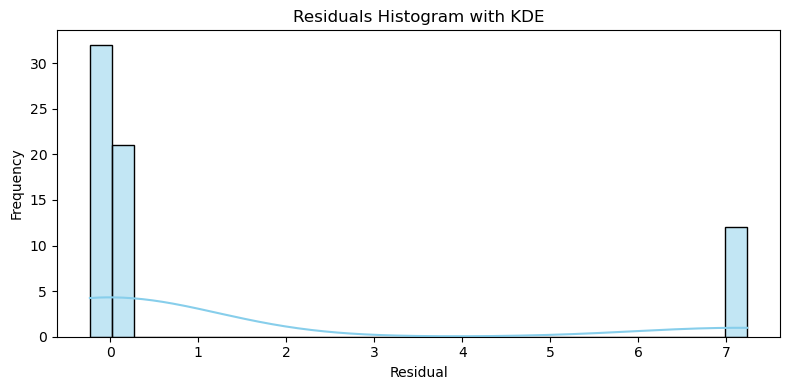

            Residual
Month               
2018-09-01  7.235010
2018-10-01  7.190975
2018-11-01  7.148683
2018-12-01  7.183689
2019-01-01  7.156417
2019-02-01  7.171432
2019-03-01  7.097537
2019-04-01  7.061151
2019-05-01  7.177986
2019-06-01  7.150858
2019-07-01  7.158364
2019-08-01  7.146827
2019-09-01 -0.054998
2019-10-01 -0.015610
2019-11-01 -0.025843
2019-12-01 -0.032235
2020-01-01  0.008287
2020-02-01 -0.024887
2020-03-01  0.101113
2020-04-01 -0.229717
2020-05-01 -0.100290
2020-06-01 -0.036008
2020-07-01 -0.156931
2020-08-01  0.024217
2020-09-01 -0.210489
2020-10-01 -0.002276
2020-11-01  0.058582
2020-12-01 -0.063598
2021-01-01 -0.156608
2021-02-01  0.078018
2021-03-01 -0.059635
2021-04-01  0.188354
2021-05-01  0.046781
2021-06-01  0.023800
2021-07-01  0.082611
2021-08-01 -0.040992
2021-09-01  0.027601
2021-10-01 -0.080977
2021-11-01  0.037983
2021-12-01  0.031661
2022-01-01  0.185523
2022-02-01  0.005851
2022-03-01 -0.011862
2022-04-01  0.157900
2022-05-01  0.072026
2022-06-01 -0

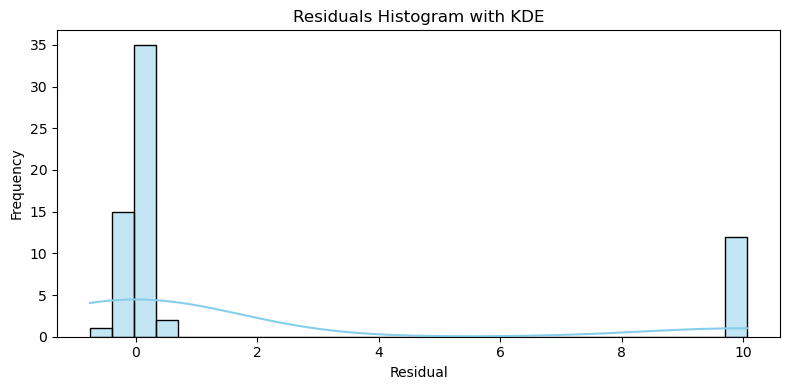

             Residual
Month                
2018-09-01  10.068218
2018-10-01  10.031122
2018-11-01  10.047218
2018-12-01  10.035248
2019-01-01   9.989526
2019-02-01   9.978393
2019-03-01   9.950349
2019-04-01   9.930412
2019-05-01  10.066259
2019-06-01  10.054563
2019-07-01  10.022978
2019-08-01  10.015948
2019-09-01  -0.039378
2019-10-01  -0.008738
2019-11-01  -0.030982
2019-12-01  -0.034059
2020-01-01  -0.039513
2020-02-01   0.024022
2020-03-01  -0.164278
2020-04-01  -0.760344
2020-05-01   0.099277
2020-06-01  -0.028753
2020-07-01   0.022674
2020-08-01   0.118393
2020-09-01  -0.149140
2020-10-01   0.106812
2020-11-01  -0.140017
2020-12-01  -0.013541
2021-01-01  -0.070151
2021-02-01  -0.012322
2021-03-01   0.124402
2021-04-01   0.407501
2021-05-01  -0.086479
2021-06-01   0.006342
2021-07-01   0.032917
2021-08-01  -0.082343
2021-09-01   0.031100
2021-10-01  -0.092581
2021-11-01   0.083347
2021-12-01   0.039084
2022-01-01   0.098951
2022-02-01   0.006572
2022-03-01   0.130126
2022-04-01

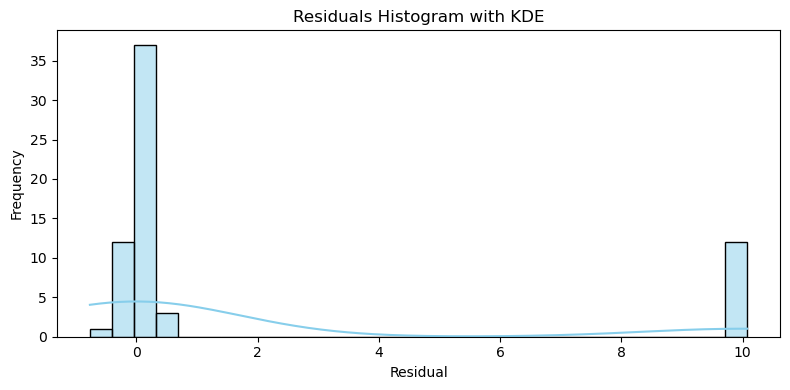

             Residual
Month                
2018-09-01  10.074025
2018-10-01  10.037797
2018-11-01   9.998787
2018-12-01  10.036925
2019-01-01  10.036864
2019-02-01   9.999461
2019-03-01   9.963612
2019-04-01   9.927168
2019-05-01  10.036588
2019-06-01  10.036745
2019-07-01  10.036727
2019-08-01   9.999052
2019-09-01  -0.036949
2019-10-01   0.003911
2019-11-01  -0.009580
2019-12-01  -0.036567
2020-01-01  -0.029520
2020-02-01  -0.002121
2020-03-01  -0.228800
2020-04-01  -0.764062
2020-05-01   0.332273
2020-06-01  -0.034764
2020-07-01  -0.018852
2020-08-01   0.146954
2020-09-01  -0.190194
2020-10-01   0.117290
2020-11-01  -0.140342
2020-12-01   0.009202
2021-01-01  -0.080624
2021-02-01   0.004184
2021-03-01   0.111735
2021-04-01   0.294839
2021-05-01  -0.124832
2021-06-01   0.056265
2021-07-01  -0.006440
2021-08-01  -0.078623
2021-09-01   0.017005
2021-10-01  -0.035834
2021-11-01   0.060997
2021-12-01   0.019941
2022-01-01   0.093678
2022-02-01  -0.005898
2022-03-01   0.357446
2022-04-01

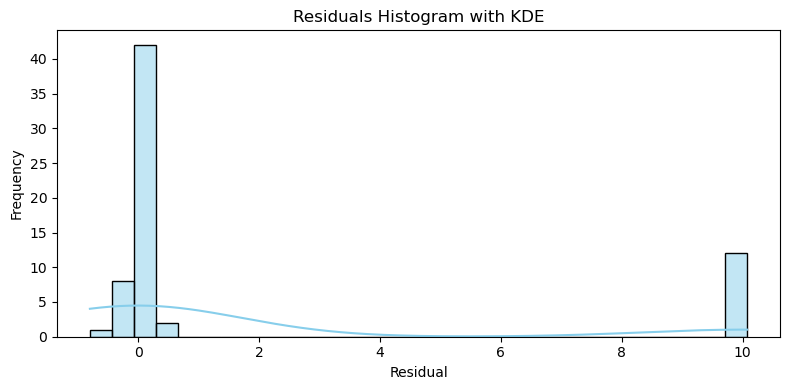

             Residual
Month                
2018-09-01  10.073830
2018-10-01  10.036728
2018-11-01  10.000015
2018-12-01  10.036644
2019-01-01  10.036649
2019-02-01   9.999991
2019-03-01   9.963571
2019-04-01   9.927154
2019-05-01  10.036760
2019-06-01  10.036655
2019-07-01  10.036618
2019-08-01  10.000012
2019-09-01  -0.037286
2019-10-01   0.000674
2019-11-01  -0.008922
2019-12-01  -0.036720
2020-01-01  -0.035598
2020-02-01  -0.007660
2020-03-01  -0.223544
2020-04-01  -0.799476
2020-05-01   0.156830
2020-06-01   0.083702
2020-07-01   0.003439
2020-08-01   0.142009
2020-09-01  -0.174840
2020-10-01   0.094280
2020-11-01  -0.116751
2020-12-01   0.001124
2021-01-01  -0.074004
2021-02-01  -0.002951
2021-03-01   0.161610
2021-04-01   0.484411
2021-05-01  -0.096619
2021-06-01  -0.010902
2021-07-01  -0.007793
2021-08-01  -0.104638
2021-09-01   0.039515
2021-10-01  -0.053536
2021-11-01   0.081282
2021-12-01   0.026712
2022-01-01   0.108341
2022-02-01   0.006200
2022-03-01   0.174556
2022-04-01

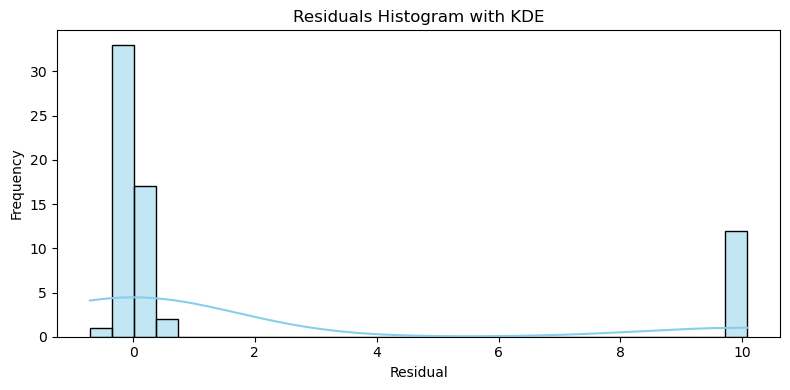

             Residual
Month                
2018-09-01  10.080107
2018-10-01  10.034022
2018-11-01   9.997826
2018-12-01  10.036022
2019-01-01  10.025974
2019-02-01  10.020190
2019-03-01   9.948923
2019-04-01   9.927177
2019-05-01  10.039576
2019-06-01  10.026089
2019-07-01  10.039574
2019-08-01  10.009807
2019-09-01  -0.044868
2019-10-01   0.010943
2019-11-01  -0.021186
2019-12-01  -0.017194
2020-01-01  -0.021861
2020-02-01  -0.029391
2020-03-01  -0.076801
2020-04-01  -0.709053
2020-05-01   0.011948
2020-06-01   0.093356
2020-07-01  -0.011385
2020-08-01   0.133714
2020-09-01  -0.187034
2020-10-01   0.128829
2020-11-01  -0.078960
2020-12-01  -0.050011
2021-01-01  -0.071368
2021-02-01   0.064616
2021-03-01  -0.002460
2021-04-01   0.411998
2021-05-01  -0.055950
2021-06-01   0.008209
2021-07-01  -0.008645
2021-08-01  -0.080610
2021-09-01   0.013962
2021-10-01  -0.067201
2021-11-01   0.098745
2021-12-01  -0.002778
2022-01-01   0.149981
2022-02-01  -0.055271
2022-03-01   0.152208
2022-04-01

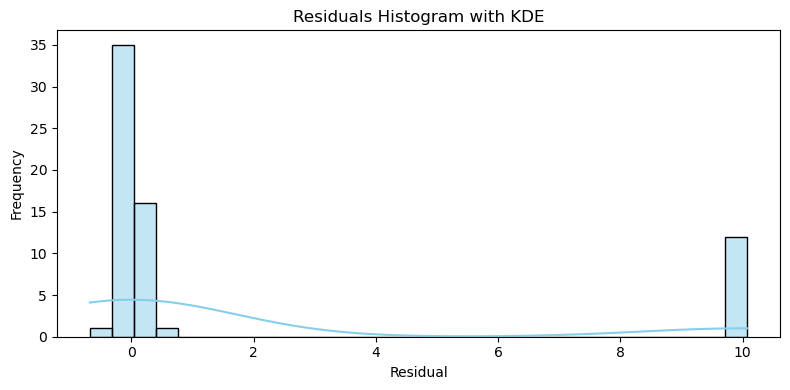

             Residual
Month                
2018-09-01  10.073836
2018-10-01  10.032928
2018-11-01  10.003805
2018-12-01  10.036674
2019-01-01  10.044719
2019-02-01   9.991897
2019-03-01   9.963575
2019-04-01   9.920085
2019-05-01  10.043816
2019-06-01  10.036674
2019-07-01  10.046444
2019-08-01   9.990172
2019-09-01  -0.037278
2019-10-01   0.019933
2019-11-01  -0.024939
2019-12-01  -0.032624
2020-01-01  -0.019550
2020-02-01  -0.021489
2020-03-01  -0.216717
2020-04-01  -0.679942
2020-05-01   0.138487
2020-06-01   0.115349
2020-07-01  -0.201261
2020-08-01   0.293661
2020-09-01  -0.200583
2020-10-01   0.048321
2020-11-01  -0.041496
2020-12-01  -0.021239
2021-01-01  -0.110939
2021-02-01   0.052922
2021-03-01   0.123760
2021-04-01   0.305852
2021-05-01  -0.047469
2021-06-01  -0.023595
2021-07-01   0.032373
2021-08-01  -0.097749
2021-09-01   0.023520
2021-10-01  -0.075543
2021-11-01   0.105440
2021-12-01   0.020384
2022-01-01   0.047349
2022-02-01   0.055615
2022-03-01   0.195116
2022-04-01

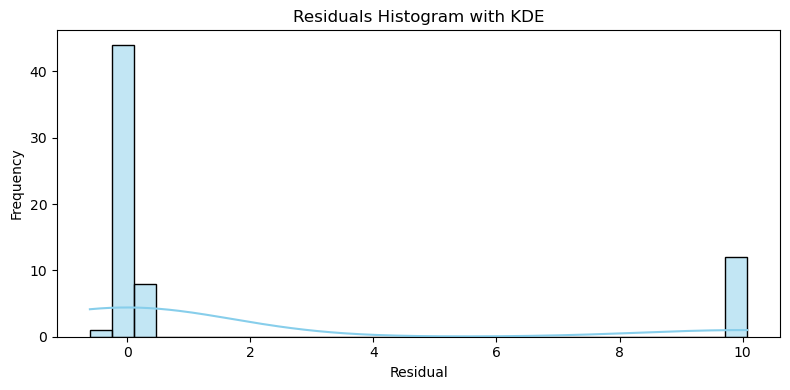

             Residual
Month                
2018-09-01  10.073836
2018-10-01  10.036023
2018-11-01  10.000709
2018-12-01  10.036674
2019-01-01  10.035568
2019-02-01  10.001048
2019-03-01   9.963575
2019-04-01   9.924497
2019-05-01  10.039404
2019-06-01  10.036674
2019-07-01  10.042123
2019-08-01   9.994493
2019-09-01  -0.037278
2019-10-01   0.002140
2019-11-01  -0.002358
2019-12-01  -0.036936
2020-01-01   0.010877
2020-02-01  -0.047879
2020-03-01  -0.209750
2020-04-01  -0.606977
2020-05-01   0.098353
2020-06-01   0.165181
2020-07-01  -0.240481
2020-08-01   0.306664
2020-09-01  -0.198908
2020-10-01   0.027615
2020-11-01  -0.012323
2020-12-01  -0.026819
2021-01-01  -0.121000
2021-02-01   0.071159
2021-03-01   0.117450
2021-04-01   0.233322
2021-05-01  -0.015066
2021-06-01  -0.042013
2021-07-01   0.041380
2021-08-01  -0.092488
2021-09-01   0.018152
2021-10-01  -0.083510
2021-11-01   0.120723
2021-12-01   0.018166
2022-01-01   0.047195
2022-02-01   0.044821
2022-03-01   0.204316
2022-04-01

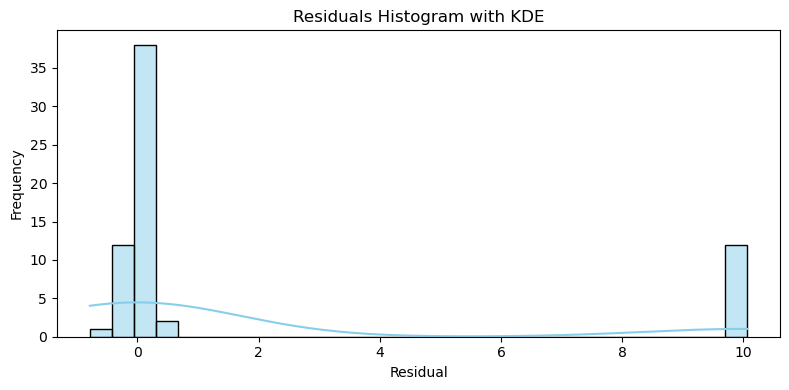

             Residual
Month                
2018-09-01  10.053536
2018-10-01  10.056251
2018-11-01   9.998733
2018-12-01  10.030092
2019-01-01  10.062138
2019-02-01   9.967252
2019-03-01   9.955917
2019-04-01   9.948979
2019-05-01  10.022472
2019-06-01  10.052847
2019-07-01  10.029905
2019-08-01  10.027700
2019-09-01  -0.057475
2019-10-01  -0.009526
2019-11-01  -0.006566
2019-12-01  -0.038610
2020-01-01  -0.049641
2020-02-01   0.028731
2020-03-01  -0.184014
2020-04-01  -0.783348
2020-05-01   0.245687
2020-06-01  -0.022591
2020-07-01   0.054593
2020-08-01   0.054426
2020-09-01  -0.167623
2020-10-01   0.107663
2020-11-01  -0.099898
2020-12-01  -0.029646
2021-01-01  -0.062275
2021-02-01   0.018658
2021-03-01   0.069228
2021-04-01   0.370339
2021-05-01  -0.073900
2021-06-01  -0.012377
2021-07-01   0.027863
2021-08-01  -0.075368
2021-09-01   0.006045
2021-10-01  -0.027992
2021-11-01   0.065110
2021-12-01   0.004262
2022-01-01   0.119550
2022-02-01  -0.002425
2022-03-01   0.206041
2022-04-01

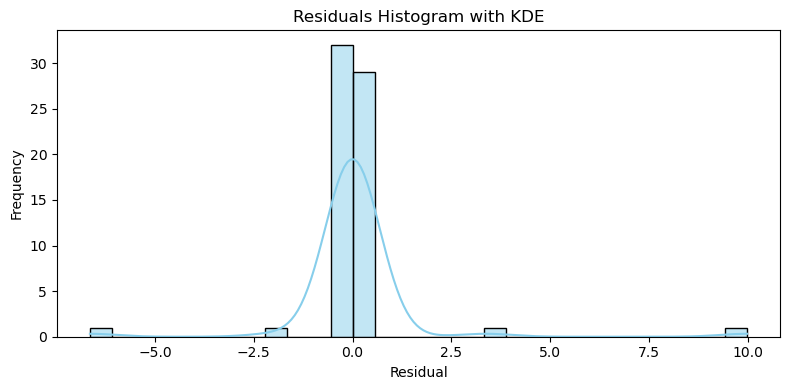

            Residual
Month               
2018-09-01  9.982559
2018-10-01 -6.644297
2018-11-01 -0.144338
2018-12-01  0.170212
2019-01-01  0.076629
2019-02-01 -0.071548
2019-03-01 -0.014823
2019-04-01 -0.048311
2019-05-01 -0.020855
2019-06-01 -0.000213
2019-07-01  0.081902
2019-08-01 -0.083237
2019-09-01 -1.947420
2019-10-01  3.365433
2019-11-01  0.050319
2019-12-01 -0.114363
2020-01-01  0.006587
2020-02-01 -0.098218
2020-03-01 -0.083847
2020-04-01  0.016131
2020-05-01  0.241982
2020-06-01  0.150432
2020-07-01 -0.112648
2020-08-01 -0.054553
2020-09-01 -0.143837
2020-10-01 -0.001807
2020-11-01  0.096525
2020-12-01  0.020840
2021-01-01 -0.030298
2021-02-01  0.000397
2021-03-01  0.038129
2021-04-01  0.051271
2021-05-01 -0.081555
2021-06-01 -0.001356
2021-07-01 -0.165358
2021-08-01  0.045918
2021-09-01  0.032737
2021-10-01  0.179086
2021-11-01 -0.075043
2021-12-01 -0.056763
2022-01-01 -0.007074
2022-02-01  0.017477
2022-03-01  0.178041
2022-04-01 -0.235847
2022-05-01  0.098011
2022-06-01 -0

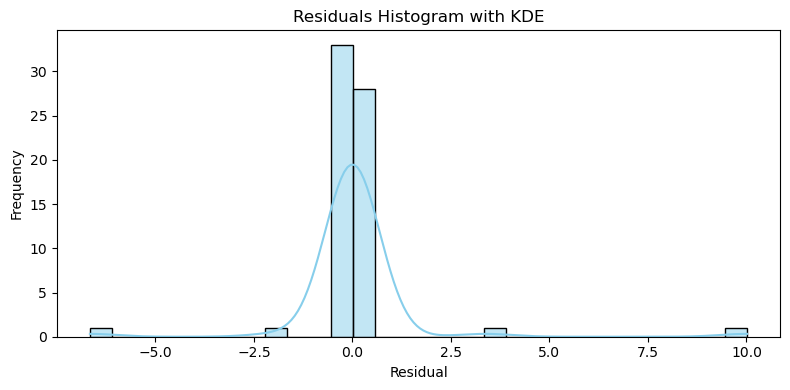

             Residual
Month                
2018-09-01  10.016375
2018-10-01  -6.663953
2018-11-01  -0.133986
2018-12-01   0.128493
2019-01-01   0.109825
2019-02-01  -0.066413
2019-03-01  -0.015940
2019-04-01  -0.048577
2019-05-01  -0.056401
2019-06-01   0.024009
2019-07-01   0.078641
2019-08-01  -0.072077
2019-09-01  -1.950957
2019-10-01   3.367610
2019-11-01   0.032020
2019-12-01  -0.061568
2020-01-01  -0.008259
2020-02-01  -0.099491
2020-03-01  -0.103729
2020-04-01  -0.003040
2020-05-01   0.291684
2020-06-01   0.133040
2020-07-01  -0.083282
2020-08-01  -0.080040
2020-09-01  -0.151286
2020-10-01  -0.002281
2020-11-01   0.093159
2020-12-01   0.025030
2021-01-01  -0.034667
2021-02-01  -0.008768
2021-03-01   0.037608
2021-04-01   0.057095
2021-05-01  -0.057608
2021-06-01  -0.009852
2021-07-01  -0.166747
2021-08-01   0.044827
2021-09-01   0.030647
2021-10-01   0.172538
2021-11-01  -0.079601
2021-12-01  -0.043393
2022-01-01  -0.011373
2022-02-01   0.021267
2022-03-01   0.169291
2022-04-01

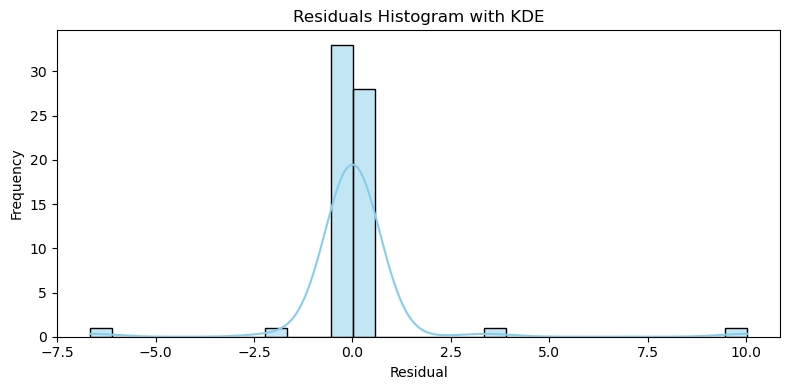

             Residual
Month                
2018-09-01  10.030862
2018-10-01  -6.674599
2018-11-01  -0.128043
2018-12-01   0.119518
2019-01-01   0.112601
2019-02-01  -0.061427
2019-03-01  -0.022072
2019-04-01  -0.037541
2019-05-01  -0.073233
2019-06-01   0.030855
2019-07-01   0.082376
2019-08-01  -0.075152
2019-09-01  -1.949006
2019-10-01   3.368441
2019-11-01   0.030233
2019-12-01  -0.053517
2020-01-01  -0.009557
2020-02-01  -0.105183
2020-03-01  -0.098796
2020-04-01  -0.021561
2020-05-01   0.326256
2020-06-01   0.119117
2020-07-01  -0.078616
2020-08-01  -0.091848
2020-09-01  -0.151554
2020-10-01  -0.000532
2020-11-01   0.099359
2020-12-01   0.011078
2021-01-01  -0.031035
2021-02-01  -0.010246
2021-03-01   0.044445
2021-04-01   0.059293
2021-05-01  -0.063022
2021-06-01  -0.009113
2021-07-01  -0.162295
2021-08-01   0.055210
2021-09-01   0.020303
2021-10-01   0.170674
2021-11-01  -0.082473
2021-12-01  -0.040127
2022-01-01  -0.006576
2022-02-01   0.023069
2022-03-01   0.164382
2022-04-01

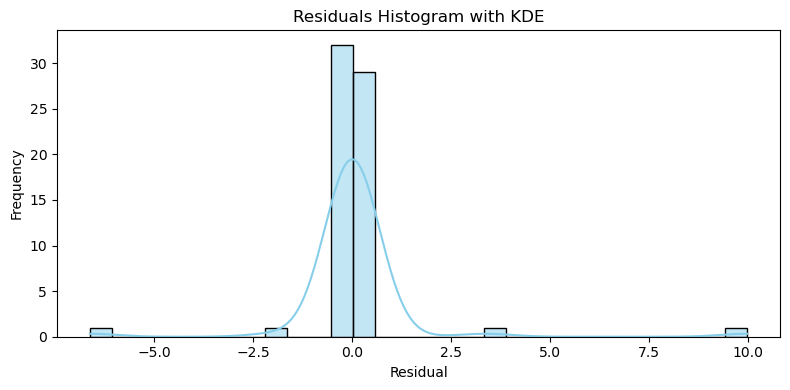

            Residual
Month               
2018-09-01  9.985382
2018-10-01 -6.632137
2018-11-01 -0.160319
2018-12-01  0.152340
2019-01-01  0.106696
2019-02-01 -0.080366
2019-03-01 -0.010221
2019-04-01 -0.063437
2019-05-01 -0.027968
2019-06-01  0.022720
2019-07-01  0.065472
2019-08-01 -0.065045
2019-09-01 -1.960224
2019-10-01  3.362219
2019-11-01  0.045823
2019-12-01 -0.078848
2020-01-01 -0.008506
2020-02-01 -0.090452
2020-03-01 -0.096734
2020-04-01  0.030408
2020-05-01  0.241803
2020-06-01  0.140089
2020-07-01 -0.099831
2020-08-01 -0.075746
2020-09-01 -0.127517
2020-10-01 -0.009213
2020-11-01  0.081269
2020-12-01  0.044299
2021-01-01 -0.044568
2021-02-01  0.019085
2021-03-01  0.008846
2021-04-01  0.072503
2021-05-01 -0.076265
2021-06-01  0.008988
2021-07-01 -0.181527
2021-08-01  0.037271
2021-09-01  0.030875
2021-10-01  0.180765
2021-11-01 -0.065385
2021-12-01 -0.059224
2022-01-01 -0.014567
2022-02-01  0.020605
2022-03-01  0.173613
2022-04-01 -0.242069
2022-05-01  0.116437
2022-06-01 -0

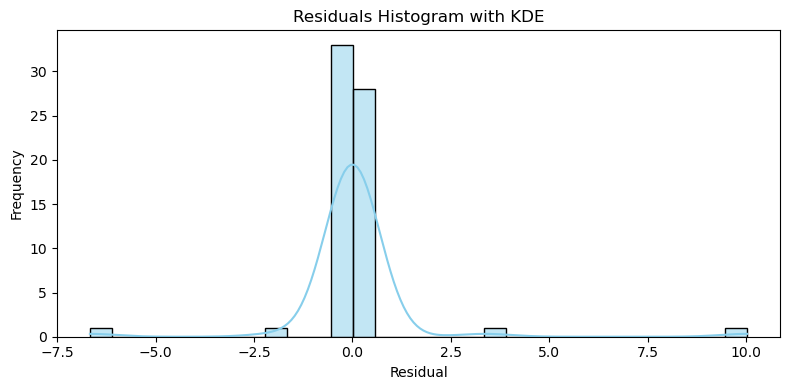

             Residual
Month                
2018-09-01  10.027159
2018-10-01  -6.670772
2018-11-01  -0.131237
2018-12-01   0.120785
2019-01-01   0.113742
2019-02-01  -0.063105
2019-03-01  -0.021349
2019-04-01  -0.040562
2019-05-01  -0.066666
2019-06-01   0.030029
2019-07-01   0.078653
2019-08-01  -0.074445
2019-09-01  -1.948419
2019-10-01   3.367724
2019-11-01   0.031945
2019-12-01  -0.054797
2020-01-01  -0.008178
2020-02-01  -0.106559
2020-03-01  -0.096339
2020-04-01  -0.017294
2020-05-01   0.315855
2020-06-01   0.119364
2020-07-01  -0.077600
2020-08-01  -0.088112
2020-09-01  -0.150891
2020-10-01  -0.002091
2020-11-01   0.097879
2020-12-01   0.018794
2021-01-01  -0.033263
2021-02-01  -0.010413
2021-03-01   0.040388
2021-04-01   0.059579
2021-05-01  -0.060589
2021-06-01  -0.012223
2021-07-01  -0.161979
2021-08-01   0.052561
2021-09-01   0.024005
2021-10-01   0.169666
2021-11-01  -0.081450
2021-12-01  -0.042063
2022-01-01  -0.007003
2022-02-01   0.024120
2022-03-01   0.166062
2022-04-01

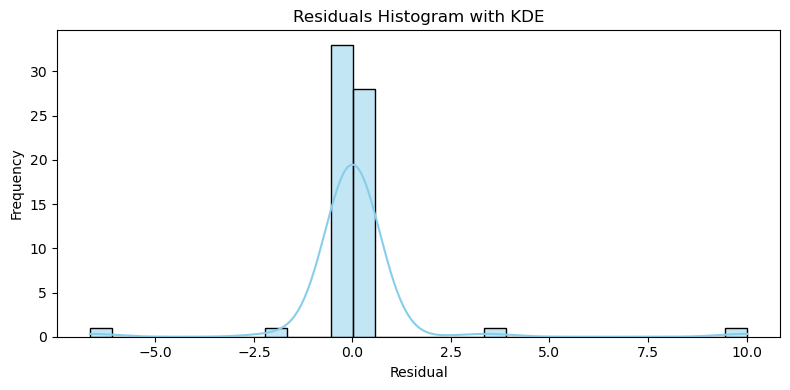

             Residual
Month                
2018-09-01  10.015435
2018-10-01  -6.662152
2018-11-01  -0.136733
2018-12-01   0.130064
2019-01-01   0.108889
2019-02-01  -0.065311
2019-03-01  -0.020390
2019-04-01  -0.038850
2019-05-01  -0.065406
2019-06-01   0.030732
2019-07-01   0.073817
2019-08-01  -0.070594
2019-09-01  -1.950244
2019-10-01   3.366780
2019-11-01   0.031385
2019-12-01  -0.060436
2020-01-01  -0.005992
2020-02-01  -0.099898
2020-03-01  -0.098929
2020-04-01  -0.007992
2020-05-01   0.294705
2020-06-01   0.125958
2020-07-01  -0.077915
2020-08-01  -0.079826
2020-09-01  -0.158404
2020-10-01   0.003489
2020-11-01   0.089213
2020-12-01   0.028999
2021-01-01  -0.035772
2021-02-01  -0.004330
2021-03-01   0.036369
2021-04-01   0.051180
2021-05-01  -0.059693
2021-06-01  -0.006913
2021-07-01  -0.166381
2021-08-01   0.047195
2021-09-01   0.034937
2021-10-01   0.161719
2021-11-01  -0.072701
2021-12-01  -0.048985
2022-01-01  -0.000794
2022-02-01   0.015312
2022-03-01   0.169012
2022-04-01

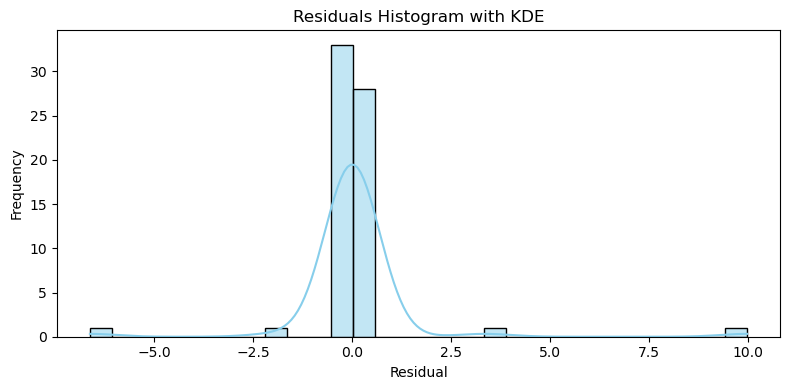

            Residual
Month               
2018-09-01  9.979889
2018-10-01 -6.631362
2018-11-01 -0.127774
2018-12-01  0.109263
2019-01-01  0.111815
2019-02-01 -0.055101
2019-03-01 -0.026706
2019-04-01 -0.040619
2019-05-01 -0.067330
2019-06-01  0.028979
2019-07-01  0.064636
2019-08-01 -0.061464
2019-09-01 -1.939613
2019-10-01  3.349150
2019-11-01  0.023883
2019-12-01 -0.035981
2020-01-01 -0.003747
2020-02-01 -0.110353
2020-03-01 -0.096636
2020-04-01 -0.014919
2020-05-01  0.308924
2020-06-01  0.124990
2020-07-01 -0.065367
2020-08-01 -0.088511
2020-09-01 -0.146080
2020-10-01 -0.010437
2020-11-01  0.094148
2020-12-01  0.019120
2021-01-01 -0.027956
2021-02-01 -0.006726
2021-03-01  0.028724
2021-04-01  0.073069
2021-05-01 -0.070132
2021-06-01 -0.000239
2021-07-01 -0.169782
2021-08-01  0.053236
2021-09-01  0.026234
2021-10-01  0.164603
2021-11-01 -0.077977
2021-12-01 -0.045092
2022-01-01 -0.010108
2022-02-01  0.030412
2022-03-01  0.169720
2022-04-01 -0.227638
2022-05-01  0.086670
2022-06-01 -0

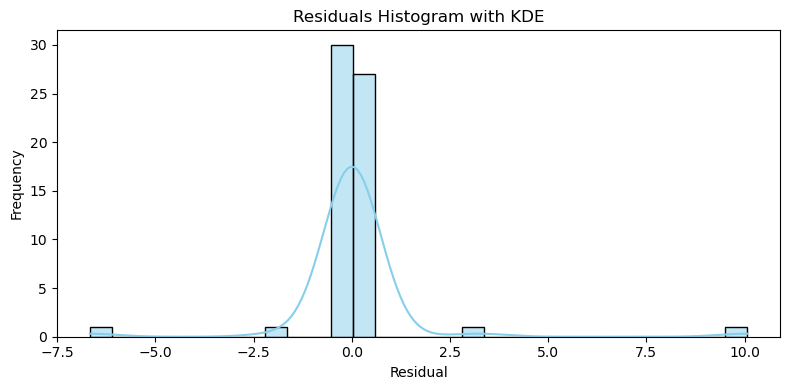

             Residual
Month                
2019-01-01  10.064143
2019-02-01  -6.665772
2019-03-01  -0.001578
2019-04-01  -0.047940
2019-05-01  -0.071894
2019-06-01   0.040750
2019-07-01   0.069211
2019-08-01  -0.068717
2019-09-01   0.059733
2019-10-01   0.020135
2019-11-01  -0.105055
2019-12-01   0.052743
2020-01-01  -1.901508
2020-02-01   3.227925
2020-03-01  -0.090111
2020-04-01   0.033055
2020-05-01   0.321812
2020-06-01   0.111191
2020-07-01  -0.073863
2020-08-01  -0.095074
2020-09-01  -0.148384
2020-10-01   0.002410
2020-11-01   0.070332
2020-12-01   0.040965
2021-01-01  -0.018112
2021-02-01   0.062697
2021-03-01   0.071121
2021-04-01   0.068964
2021-05-01  -0.072622
2021-06-01  -0.017573
2021-07-01  -0.150675
2021-08-01   0.049504
2021-09-01   0.028077
2021-10-01   0.160196
2021-11-01  -0.084493
2021-12-01  -0.036301
2022-01-01  -0.000061
2022-02-01   0.023440
2022-03-01   0.168591
2022-04-01  -0.232915
2022-05-01   0.102887
2022-06-01  -0.141925
2022-07-01  -0.172431
2022-08-01

KeyboardInterrupt: 

In [214]:
all_assumptions = []

for macro in ar_orders.keys():
    for asset in df.columns:
        if asset == macro:
            continue
        try:
            metrics, assumptions = run_model(df, macro, asset, plot=False)
            result_row = {
                "Macro": macro,
                "Asset": asset,
                "Breusch-Pagan p": assumptions["Breusch-Pagan p"],
                "Breusch-Godfrey p": assumptions["Breusch-Godfrey p"],
                "Shapiro p": assumptions["Shapiro p"],
                "Anderson stat": assumptions["Anderson stat"],
                "Mean resid": assumptions["Mean resid"],
            }

            # Optionally flatten Anderson critical values at 5% level
            for level, crit_val in assumptions["Anderson crit"]:
                if level == 5:
                    result_row["Anderson 5% crit"] = crit_val

            all_assumptions.append(result_row)

        except Exception as e:
            print(f"Failed for Macro: {macro}, Asset: {asset} — {e}")
assumptions_df = pd.DataFrame(all_assumptions)


In [ ]:
plt.plot()

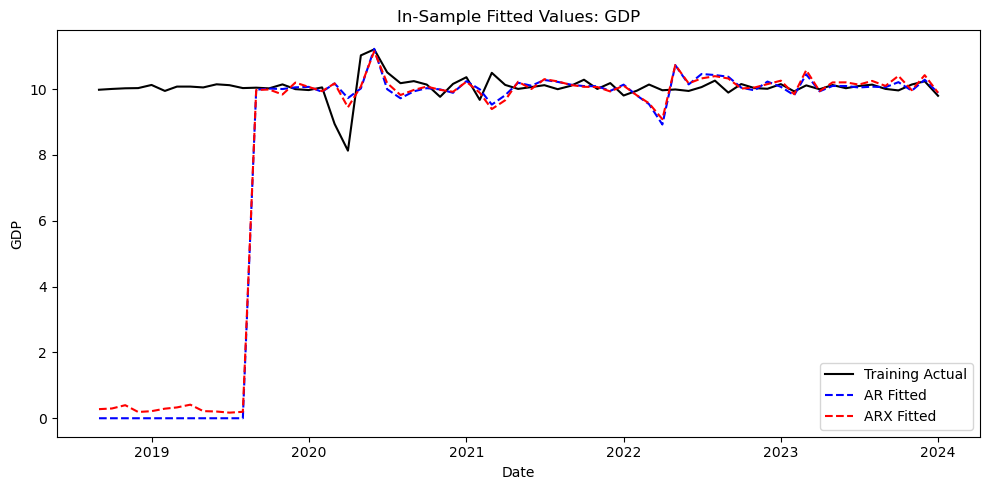

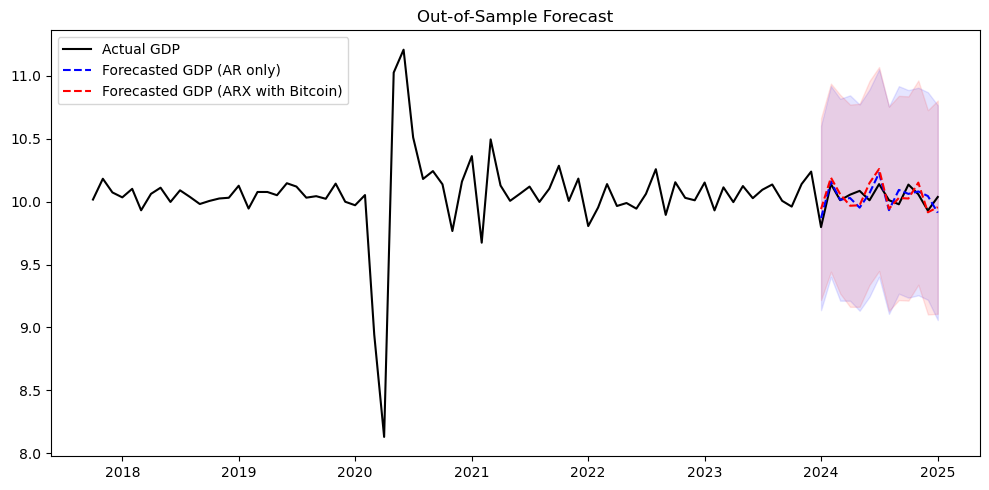

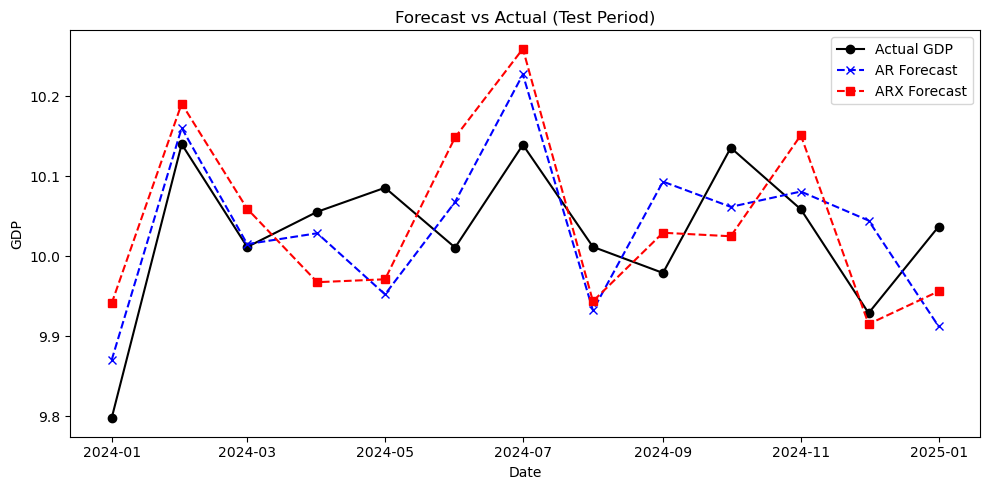

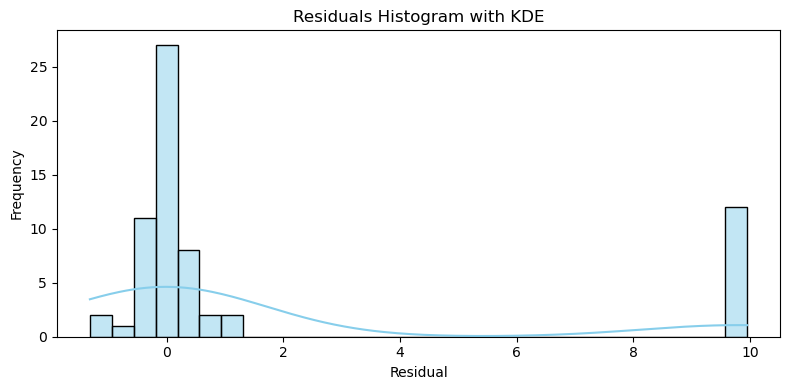

            Residual
Month               
2018-09-01  9.704613
2018-10-01  9.708795
2018-11-01  9.628252
2018-12-01  9.840890
2019-01-01  9.911406
2019-02-01  9.654139
2019-03-01  9.747977
2019-04-01  9.664363
2019-05-01  9.834157
2019-06-01  9.942132
2019-07-01  9.949530
2019-08-01  9.835577
2019-09-01  0.068905
2019-10-01  0.035195
2019-11-01  0.306441
2019-12-01 -0.199015
2020-01-01 -0.094556
2020-02-01  0.114709
2020-03-01 -1.230854
2020-04-01 -1.317821
2020-05-01  0.942629
2020-06-01  0.058827
2020-07-01  0.325406
2020-08-01  0.359950
2020-09-01  0.268251
2020-10-01  0.060174
2020-11-01 -0.212363
2020-12-01  0.239688
2021-01-01  0.136993
2021-02-01 -0.216264
2021-03-01  1.100438
2021-04-01  0.467299
2021-05-01 -0.217857
2021-06-01  0.059012
2021-07-01 -0.182794
2021-08-01 -0.236746
2021-09-01 -0.021829
2021-10-01  0.214740
2021-11-01 -0.058389
2021-12-01  0.253868
2022-01-01 -0.299120
2022-02-01  0.145565
2022-03-01  0.569655
2022-04-01  0.879416
2022-05-01 -0.742456
2022-06-01 -0

(            MAE      RMSE        R2  MAPE (%)    Order
 Model                                                 
 AR     0.071666  0.082941  0.169661   0.71517  (2,0,0)
 ARX    0.086006  0.093775 -0.061426   0.85757  (2,0,0),
 {'Breusch-Pagan p': 0.020335977236294486,
  'Breusch-Godfrey p': 0.1013329541111769,
  'Shapiro p': 1.2656799638974315e-12,
  'Anderson stat': 14.037198941614108,
  'Anderson crit': [(15.0, 0.546),
   (10.0, 0.621),
   (5.0, 0.746),
   (2.5, 0.87),
   (1.0, 1.034)],
  'Mean resid': 1.791448453850899})

In [217]:
run_model(df, 'GDP', 'Bitcoin', plot=True)

In [197]:
assumptions_df

,Macro,Asset,Breusch-Pagan p,Breusch-Godfrey p,Shapiro p,Anderson stat,Mean resid,Anderson 5% crit
0,LFPR,Bitcoin,2.544098e-02,8.378088e-01,4.604846e-15,20.303132,1.568337,0.751
1,LFPR,Litecoin,2.625134e-02,8.252198e-01,4.713125e-15,20.255451,1.556029,0.751
2,LFPR,XRP,1.719781e-01,8.918551e-01,4.601522e-15,20.300403,1.570644,0.751
3,LFPR,Ethereum,3.623515e-03,8.550460e-01,4.718696e-15,20.236982,1.555332,0.751
4,LFPR,Dogecoin,7.442308e-01,9.364476e-01,4.514124e-15,20.342889,1.575018,0.751
5,LFPR,Cardano,2.130466e-02,8.875469e-01,1.665819e-14,18.905335,1.657680,0.749
6,LFPR,Tether,4.752557e-01,8.189524e-01,4.502773e-15,20.360968,1.574898,0.751
7,LFPR,USD Coin,2.926241e-01,8.314273e-01,7.638772e-13,15.006459,1.942171,0.743
8,LFPR,VIX,2.298203e-06,8.507131e-01,4.419881e-15,20.303183,1.602797,0.751
9,LFPR,MOVE,3.005103e-01,8.683819e-01,4.488012e-15,20.361971,1.579782,0.751


## Assumption Testing Results

In [159]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # (optional) Show all columns
pd.set_option("display.width", None)  # Don't wrap columns
pd.set_option("display.max_colwidth", None)  # Don't truncate cell content
display(assumptions_df) 

,Macro,Asset,Breusch-Pagan p,Breusch-Godfrey p,Shapiro p,Anderson stat,Mean resid,Anderson 5% crit
0,LFPR,Bitcoin,2.090908e-04,9.357522e-01,5.093184e-11,3.667762,0.000008,0.751
1,LFPR,Litecoin,2.674970e-03,7.102086e-01,2.605672e-14,8.624639,0.000448,0.751
2,LFPR,XRP,1.684209e-01,9.388852e-01,2.051228e-14,8.757307,-0.000138,0.751
3,LFPR,Ethereum,3.545131e-06,6.845818e-01,3.556436e-14,8.370645,0.000623,0.751
4,LFPR,Dogecoin,9.138133e-01,9.466320e-01,5.354270e-14,8.021754,0.000389,0.751
5,LFPR,Cardano,1.095766e-03,8.527666e-01,5.020292e-10,3.107486,0.000046,0.748
6,LFPR,Tether,9.711416e-01,7.302268e-01,3.606248e-14,8.355229,0.000071,0.750
7,LFPR,USD Coin,9.112712e-01,8.290669e-01,3.809122e-13,8.156905,-0.000066,0.743
8,LFPR,CPI,2.864707e-04,5.318348e-01,2.274035e-13,6.677980,-0.001431,0.751
9,LFPR,r,5.744520e-01,1.734532e-01,9.869124e-04,1.384749,-0.000223,0.751


## All Macro & Crypto Combination

In [151]:
results_list = []
asset = 'Bitcoin'
for macro in macro_list:
        # Run model, plot=False to skip plotting in batch run
        metrics_df, assumptions_df = run_model(df.copy(), macro, asset, plot=False)
        
        # metrics_df is a DataFrame with index Model (AR, ARX) and columns MAE, RMSE, R2, MAPE, Order
        # Add macro and asset columns for clarity
        metrics_df['Macro'] = macro
        metrics_df['Asset'] = asset
        
        results_list.append(metrics_df.reset_index())
# Combine all results into one DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Rearrange columns to show Model, Macro, Asset, and errors only
final_results = final_results[['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2', 'MAPE (%)']]

# Format float columns for better readability
float_cols = ['MAE', 'RMSE', 'R2']
final_results[float_cols] = final_results[float_cols]

In [152]:
final_results

,Model,Macro,Asset,MAE,RMSE,R2,MAPE (%)
0,AR,LFPR,Bitcoin,0.000970,0.001393,-0.107494,3.884704e+13
1,ARX,LFPR,Bitcoin,0.001303,0.001733,-0.715369,1.959653e+14
2,AR,CPI,Bitcoin,0.001906,0.002209,-1.784968,2.542478e+02
3,ARX,CPI,Bitcoin,0.001327,0.001520,-0.318316,7.294303e+02
4,AR,r,Bitcoin,0.015983,0.026451,-0.575121,3.846154e+01
5,ARX,r,Bitcoin,0.059563,0.070055,-10.048567,1.290245e+16
6,AR,M1,Bitcoin,0.002328,0.002892,-1.462089,9.913263e+01
7,ARX,M1,Bitcoin,0.021705,0.028498,-238.135794,4.678659e+03
8,AR,GDP,Bitcoin,0.002860,0.003373,0.275509,1.136544e+02
9,ARX,GDP,Bitcoin,0.002727,0.003231,0.335016,1.072165e+02


### Combinations Where Adding Asset Data Improves the Model

In [153]:
# Reshape for comparison
df_wide = final_results.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2', 'MAPE (%)']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_MAPE'] = df_wide['MAPE (%)_ARX'] < df_wide['MAPE (%)_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_MAPE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'MAPE (%)_AR', 'MAPE (%)_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")


# Partial wins
print("\n Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX']])

print("\n Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX']])

print("\n Combinations where ARX has lower MAPE:")
display(df_wide[df_wide['ARX_better_MAPE']][['Macro', 'Asset', 'MAPE (%)_AR', 'MAPE (%)_ARX']])

print("\n Combinations where ARX has higher R²:")
display(df_wide[df_wide['ARX_better_R2']][['Macro', 'Asset', 'R2_AR', 'R2_ARX']])

Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):


,Macro,Asset,MAE_AR,MAE_ARX,RMSE_AR,RMSE_ARX,MAPE (%)_AR,MAPE (%)_ARX,R2_AR,R2_ARX
3,GDP,Bitcoin,0.00286,0.002727,0.003373,0.003231,113.654388,107.21654,0.275509,0.335016



 Combinations where ARX has lower MAE:


,Macro,Asset,MAE_AR,MAE_ARX
0,CC,Bitcoin,0.045138,0.041595
1,CPI,Bitcoin,0.001906,0.001327
3,GDP,Bitcoin,0.002860,0.002727



 Combinations where ARX has lower RMSE:


,Macro,Asset,RMSE_AR,RMSE_ARX
0,CC,Bitcoin,0.062740,0.059455
1,CPI,Bitcoin,0.002209,0.001520
2,EX,Bitcoin,0.008453,0.008172
3,GDP,Bitcoin,0.003373,0.003231
4,IM,Bitcoin,0.028908,0.027630



 Combinations where ARX has lower MAPE:


,Macro,Asset,MAPE (%)_AR,MAPE (%)_ARX
3,GDP,Bitcoin,113.654388,107.21654



 Combinations where ARX has higher R²:


,Macro,Asset,R2_AR,R2_ARX
1,CPI,Bitcoin,-1.784968,-0.318316
2,EX,Bitcoin,-0.298822,-0.213998
3,GDP,Bitcoin,0.275509,0.335016
4,IM,Bitcoin,-0.184342,-0.081915


## Testing Individual Combinations

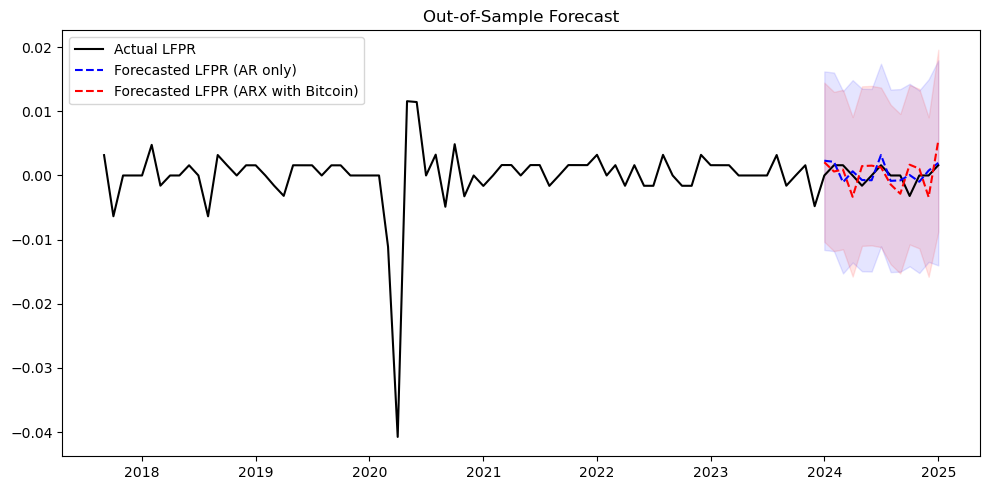

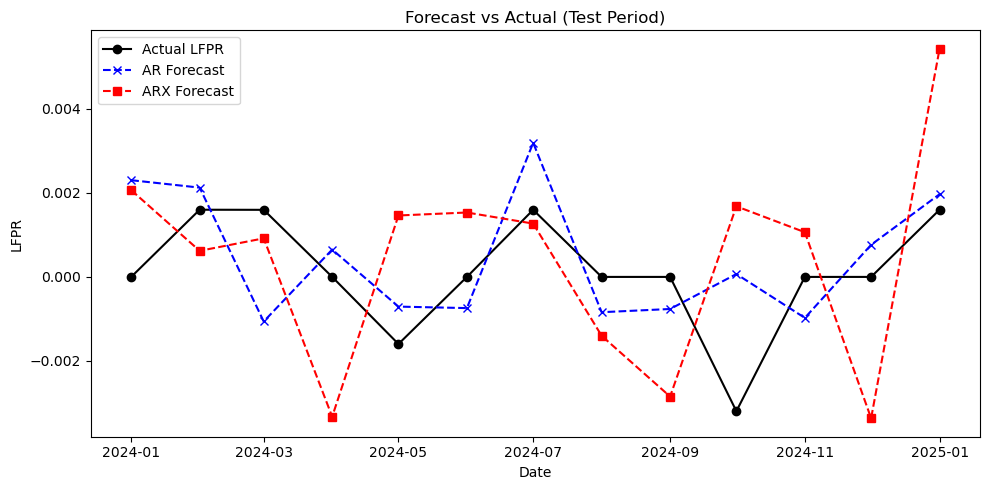

(            MAE      RMSE        R2      MAPE (%)    Order
 Model                                                     
 AR     0.001256  0.001533 -0.341615  2.437361e+14  (2,0,0)
 ARX    0.002257  0.002623 -2.930067  5.403011e+14  (2,0,0),
 {'Breusch-Pagan p': 0.00020909077740281686,
  'Breusch-Godfrey p': 0.9357522349449415,
  'Shapiro p': 7.122645345192965e-05,
  'Anderson stat': 0.8730193001586457,
  'Anderson crit': [(15.0, 0.549),
   (10.0, 0.626),
   (5.0, 0.751),
   (2.5, 0.876),
   (1.0, 1.042)],
  'Mean resid': 7.8786705299221e-05})

In [176]:
macro = 'LFPR'
asset = 'Bitcoin'
run_model(df.copy(), macro, asset, plot=True)

## Finding Optimal Crypto Lag

In [155]:
# def find_optimal_lag(df, macro, asset, max_lag=6, verbose=False):
#     best_lag = None
#     best_improvement = np.inf
#     best_metrics = None

#     results = []

#     for lag in range(0, max_lag + 1):
#         # Temporarily override lag

#         try:
#             metrics = run_model(df, macro, asset, lag)
#             ar = metrics.loc['AR']
#             arx = metrics.loc['ARX']

#             delta_mape = arx['MAPE (%)'] - ar['MAPE (%)']
#             results.append({
#                 'Lag': lag,
#                 'ΔMAPE': delta_mape,
#             })

#             if delta_mape < best_improvement:
#                 best_lag = lag
#                 best_improvement = delta_mape
#                 best_metrics = metrics

#             if verbose:
#                 print(f"Lag {lag}: ΔMAPE = {delta_mape:.2f}")

#         except Exception as e:
#             print(f"Lag {lag}: Failed with error: {e}")
#             continue

#     results_df = pd.DataFrame(results)
#     return best_lag, best_improvement, results_df, best_metrics


In [156]:
# for macro in ar_orders.keys():
#     best_lag, _, _, _ = find_optimal_lag(df, macro, asset="Bitcoin", max_lag=6)
    
#     if best_lag is not None:
#         ar_orders[macro]["VIX_lag"] = best_lag
#     else:
#         ar_orders[macro]["VIX_lag"] = np.nan 